# Binäre Klassifizierung der Exzellenten Wikipedia Artikel

In [ ]:
! pip install transformers
! pip install pandas
! conda install numpy
! pip install imblearn
! pip install seaborn

# ONLY for apple slicon
!conda install pytorch torchvision torchaudio -c pytorch-nightly

In [50]:
# imports
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

from transformers import BertTokenizer
from torch import nn
from transformers import BertModel

from torch.optim import Adam
from tqdm import tqdm

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# static var
CSV_FILE = "./articles_meta_backup.csv"

## Regelbasierte Lösung
### Mauelle Feature Extraction und Decision Tree

Eine manuelle Lösung ist aufgrund der Komplexität und der nicht regelbasierten Auswahl der exzellenten Wikipedia Artikel durch die Wikipedia Community. Da die Artikel gewählt werden und ausschließlich grundsätzliche Guidelines gegeben sind. Daher wurde für die Lösung dieser Aufgabe ein regelbasierter Ansatz gewählt, welcher die Regeln auf der Basis einiger Features automatisiert Regeln erlernt. Dafür wurden zunächst manuell Features extrahiert, welche anschließend in ein Decision Tree gegeben werden können. Der Decision Tree erlernt in dem Training eine Reihe an manuelle Regeln, anhand welcher anschließend die Artikel klassifiziert werden können.

### Feature Extraktion

Für den regelbasierten Ansatz wurden zunächt Features extrahiert, anahnd welcher anschließend klassifiziert werden soll.
Dies erfolgte auf der Grundlage von Wikipedia angegebenen besonderheiten von exzellenten Artiklen.

In [ ]:
# get number of words

# calculate TF-Idf



# get number of images
# calculated in the data preprocessing for better performance 

# get number of citations
# calculated in the data preprocessing for better performance 

### Data Balancing
Durchführen eines Undersamplings, sodass die selbe Anzahl Daten für exzellente und nicht exzellente Artikel in dem Datenset enthalten sind.

In [25]:
original_meta_data = pd.read_csv(CSV_FILE, header=0, index_col=0)
X = original_meta_data.drop(['is_excellent'], axis=1)
Y = original_meta_data['is_excellent']

rus = RandomUnderSampler(random_state=42)
X, Y = rus.fit_resample(X, Y)
print('Klassenverteilung: %s \n' % Counter(Y))

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.3, random_state=42)
print('Verteilung der Samples:')
print('  Trainingsdatenset: %s, Testdatenset: %s' % (len(Y_train), len(X_train)))

Klassenverteilung: Counter({False: 2671, True: 2671}) 

Verteilung der Samples:
  Trainingsdatenset: 3739, Testdatenset: 3739


<Axes: >

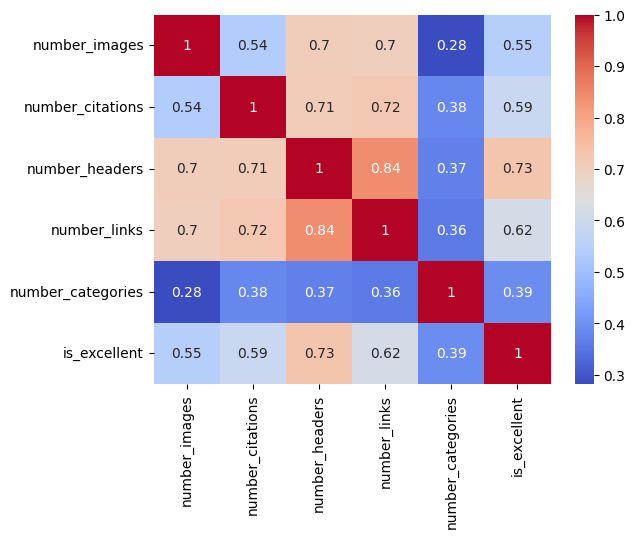

In [64]:
#fig, (ax1, ax2) = plt.subplots(1, 1)
df_undersample = pd.concat([X,Y], axis=1)
sns.heatmap(df_undersample.corr(), annot=True, cmap='coolwarm')

Bei der Coorelationsmatrix ist auffällig, dass die Anzahl der zugeordneten Kategorien mit keiner weiteren Variable stark korreliert. Die restlichen Variablen, aussgenommen das Label, korrelieren deutlich stärker miteinander. Das ist auf die Artikellänge, und der somit für alle Variablen abhänigen Anzahl zurückzuführen.
Das Label korreliert am stärksten mit der Anzahl der Titel in einem Artikel.

### Descision Tree

#### Training des Decision Tree

In [46]:
decision_tree = tree.DecisionTreeClassifier(max_depth=5)
decision_tree = decision_tree.fit(X_train,Y_train)

y_pred = decision_tree.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))


Accuracy: 0.9688084840923269


#### Visualisierug der erlernten Regeln

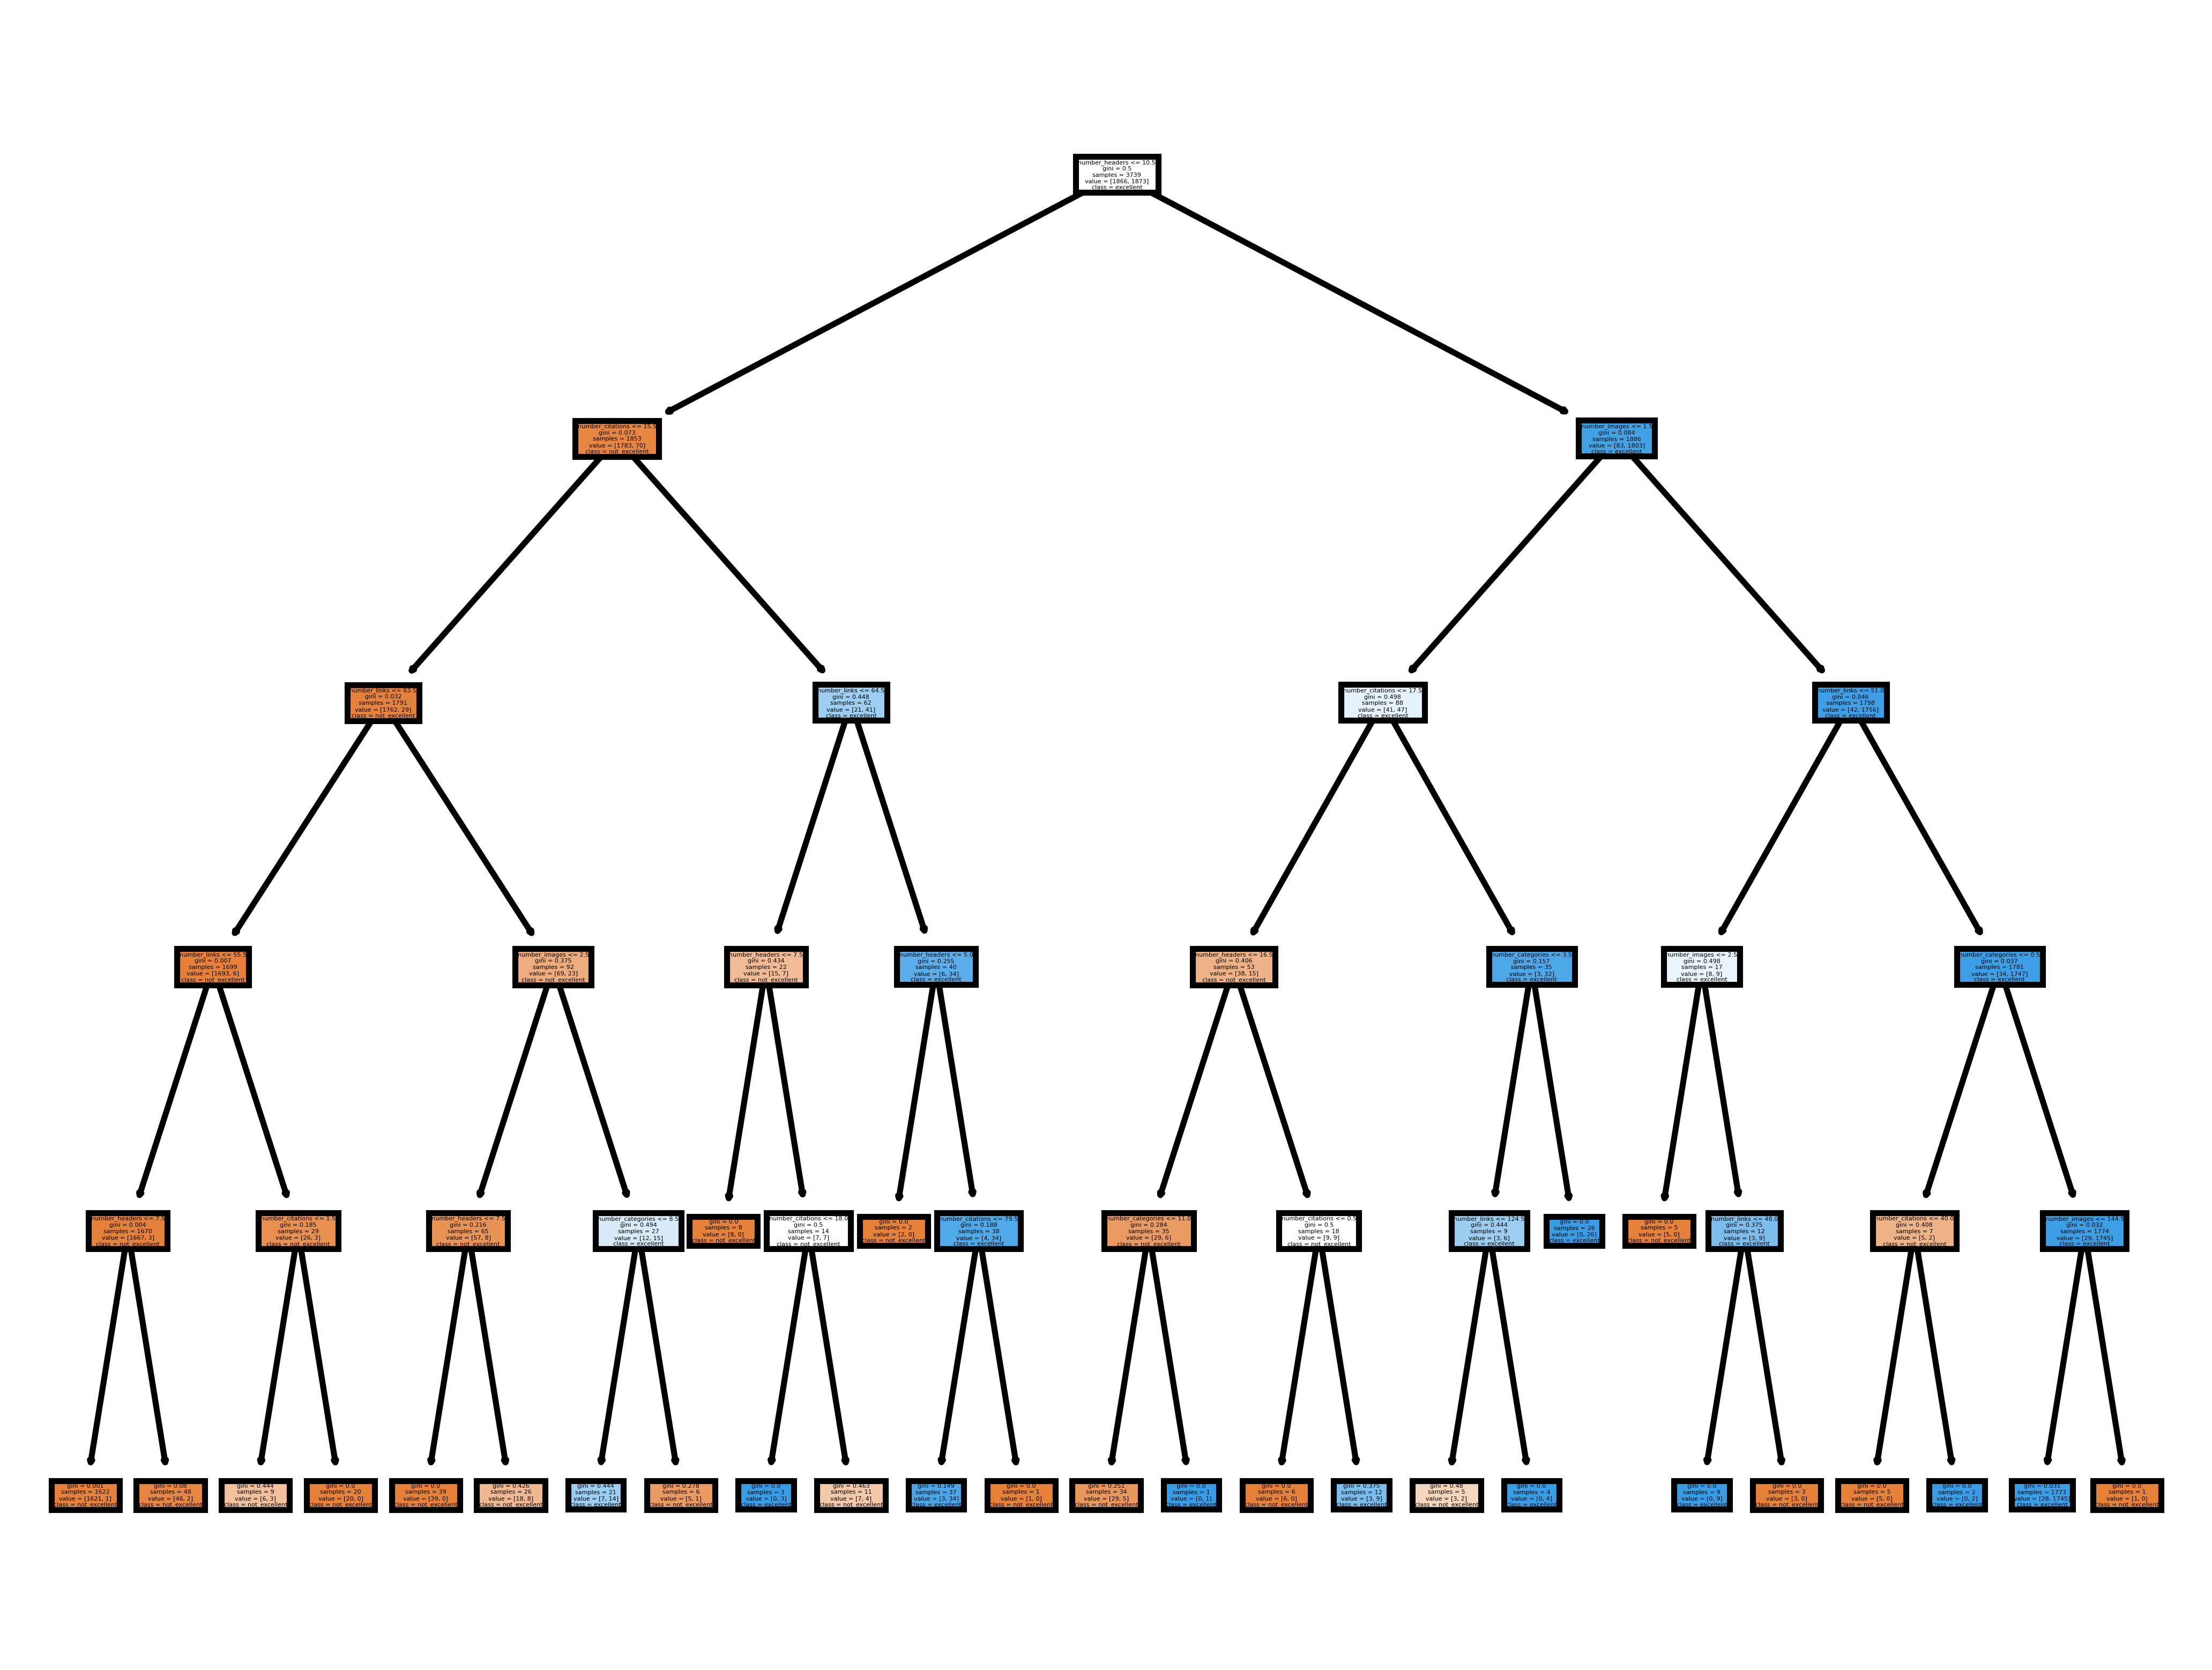

In [49]:
fig, axes = plt.subplots(dpi=800)

tree.plot_tree(decision_tree,
           feature_names = X.columns.values.tolist(), 
           class_names=['not_excellent', 'excellent'],
           filled = True)
fig.savefig("./explanation/tree_viz.png")

## Deep Learning Lösung
### BERT Classifier
Mit Änderungen entommen aus: https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f


In [ ]:
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

In [19]:
# random seed for re
np.random.seed(112)

## config tokenizer ##
# pretrained tokenizer model
PRETRAINED_TOKENIZER_MODEL_NAME = 'bert-base-german-cased' # 'bert-base-german-cased' for german or 'bert-base-multilingual-cased'
# size of output tensor
MAX_SEQUENZ_LENGTH = 512
#
PADDING = 'max_length'
#
TURNCATION = True
#
RETURN_TRNSORS = 'pt'

## training config ##
PRETRAINED_MODEL_NAME = 'bert-base-german-cased' # 'bert-base-multilingual-cased' # Best model for text in other language than english
EPOCHS = 10
LR = 1e-6

# tokenzier for preprocessing the text
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_TOKENIZER_MODEL_NAME)
# output labels
labels = {'not_excellent':0,
          'excellent':1
          }

# demo of tokenizer function
example_text = ['Wikipedia', 'The Germann Wikipedia Dump as 26GB of text']
bert_input = tokenizer(example_text,padding=PADDING, max_length = MAX_SEQUENZ_LENGTH, 
                       truncation=TURNCATION, return_tensors=RETURN_TRNSORS)

# tokenizer output => array[2]:
# 0. input_ids: id representation of each token
print(bert_input['input_ids'])
# 1. token_type_ids: binary mask that identifies in which sequence a token belongs
print(bert_input['token_type_ids'])
# 3. attention_mask: binary mask that identifies whether a token is a real word or just padding
print(bert_input['attention_mask'])

tensor([[    3, 15815, 16640,  ...,     0,     0,     0],
        [    3,  1233,  6594,  ...,     0,     0,     0]])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [13]:
for i in bert_input['input_ids']:
    print(i)

tensor([    3, 15815, 16640,  3748, 26903,     4,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

### Datenset Klasse

In [20]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df) -> None:

        self.labels = [labels[label] for label in df['Label']]
        self.texts = [tokenizer(text, padding=PADDING, max_length = MAX_SEQUENZ_LENGTH, 
                       truncation=TURNCATION, return_tensors=RETURN_TRNSORS) for text in df['Text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

Anzahl Artikel:  5378
Davon Exzellent:  2689
4302 538 538


In [ ]:
# Dataframe must have 2 colums with 'label' and 'text'
article_count = [0,0]
list_text = []
list_labels = []
for idx, (lbl, ordner) in enumerate([['excellent', './data/exzellent'], ['not_excellent','./data/not_exzellent']]):

    articles = os.listdir(ordner)
    for article in articles:
        dateipfad = os.path.join(ordner, article)
        
        with open(dateipfad, 'r') as f:
            text = f.read()
            
        list_text.append(text)
        list_labels.append(lbl)

        article_count[idx] += 1
        if article_count[1] >= article_count[0]:
            break

print('Anzahl Artikel: ', article_count[0] + article_count[1])
print('Davon Exzellent: ', article_count[0])
df = pd.DataFrame({'Text': list_text, 'Label': list_labels})

df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

### Model class

In [21]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(PRETRAINED_MODEL_NAME)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    # forward network for classification
    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids=input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

### Training Loop

In [22]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = torch.device("mps")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        model = model.to(device)
        criterion = criterion.to(device)
    elif use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()


    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
              
model = BertClassifier()
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/2151 [00:00<?, ?it/s]/Users/janmoormann/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/torch/optim/optimizer.py:243: UserWarning: 'has_cuda' is deprecated,

Epochs: 1 | Train Loss:  0.270                 | Train Accuracy:  0.000                 | Val Loss:  0.123                 | Val Accuracy:  0.000


100%|██████████| 2151/2151 [15:10<00:00,  2.36it/s]


Epochs: 2 | Train Loss:  0.101                 | Train Accuracy:  0.000                 | Val Loss:  0.093                 | Val Accuracy:  0.000


100%|██████████| 2151/2151 [14:05<00:00,  2.55it/s]


Epochs: 3 | Train Loss:  0.068                 | Train Accuracy:  0.000                 | Val Loss:  0.082                 | Val Accuracy:  0.000


100%|██████████| 2151/2151 [14:24<00:00,  2.49it/s]


Epochs: 4 | Train Loss:  0.043                 | Train Accuracy:  0.000                 | Val Loss:  0.086                 | Val Accuracy:  0.000


100%|██████████| 2151/2151 [16:00<00:00,  2.24it/s] 


Epochs: 5 | Train Loss:  0.028                 | Train Accuracy:  0.000                 | Val Loss:  0.086                 | Val Accuracy:  0.000


100%|██████████| 2151/2151 [14:28<00:00,  2.48it/s]


Epochs: 6 | Train Loss:  0.019                 | Train Accuracy:  0.000                 | Val Loss:  0.091                 | Val Accuracy:  0.000


100%|██████████| 2151/2151 [14:06<00:00,  2.54it/s]


Epochs: 7 | Train Loss:  0.011                 | Train Accuracy:  0.000                 | Val Loss:  0.108                 | Val Accuracy:  0.000


  8%|▊         | 172/2151 [01:09<12:54,  2.56it/s]

### Evaluierung


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        model = model.to(device)
    elif use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

Test Accuracy:  0.946


In [ ]:
evaluate(model, df_test)

### Test trained Bert Modell